In [171]:
# !sudo apt install swig

In [172]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

# Initializing

In [25]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from utils import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Data Import and Preprocessing

In [2]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "UL", "XOM"
]
START_DATE = '2011-01-01'
END_DATE = '2023-12-31'
print(len(TEST_SET))

##COVARIATE 1: PRICES

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()

10


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (32700, 8)


In [3]:
##COVARIATES 2,3: VIX, FEAR/GREED INDEX

combined_spy_vix_fear_greed = pd.read_csv('datasets/VIX_feargreed/spy_vix_fear_greed_2011_2023.csv')


portfolio_raw_df['date'] = pd.to_datetime(portfolio_raw_df['date'])
combined_spy_vix_fear_greed['Date'] = pd.to_datetime(combined_spy_vix_fear_greed['Date'])


df_portfolio_comb = pd.merge(portfolio_raw_df, combined_spy_vix_fear_greed, left_on='date', right_on='Date', how='left')


df_portfolio_comb = df_portfolio_comb.drop(columns=['Date'])
df_portfolio_comb['date'] = df_portfolio_comb['date'].dt.strftime('%Y-%m-%d')

In [4]:
##COVARIATE 4: STOCK HISTORICAL RATINGS

FMP_historical_ratings = pd.read_csv('datasets/historical_ratings/FMP_historical_ratings.csv')

df_portfolio_comb_2 = df_portfolio_comb.merge(
    FMP_historical_ratings[['date', 'symbol', 'ratingScore', 'ratingDetailsDCFScore', 'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore']],
    left_on=['date', 'tic'],
    right_on=['date', 'symbol'],
    how='left' )

df_portfolio_comb_2.drop(columns=['symbol'], inplace=True)

In [5]:
##COVARIATE 5: Macro Indicators

expenses = pd.read_csv('datasets/macro_indicators/expenses.csv')
gdp = pd.read_csv('datasets/macro_indicators/gdp.csv')
goods_services = pd.read_csv('datasets/macro_indicators/goods_and_services.csv')
pound_dollar = pd.read_csv('datasets/macro_indicators/pound-dollar-exchange-rate-historical-chart.csv')
unemployment = pd.read_csv('datasets/macro_indicators/unemployment.csv')
index_consumer_services = pd.read_csv('datasets/macro_indicators/index_consumer_services.csv')

df_portfolio_comb_2['date'] = pd.to_datetime(df_portfolio_comb_2['date'])
expenses['date'] = pd.to_datetime(unemployment['date'])
gdp['date'] = pd.to_datetime(gdp['DATE'])
goods_services['date'] = pd.to_datetime(goods_services['date'])
pound_dollar['date'] = pd.to_datetime(pound_dollar['date'])
unemployment['date'] = pd.to_datetime(unemployment['date'])
index_consumer_services['date'] = pd.to_datetime(index_consumer_services['date'])

df_portfolio_comb_3 = pd.merge(df_portfolio_comb_2, expenses, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, gdp, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, goods_services, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, pound_dollar, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, unemployment, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, index_consumer_services, on='date', how='left')

# Sort the dataframe by date (and optionally 'tic' if needed)
df_portfolio_comb_3 = df_portfolio_comb_3.sort_values(by=['date', 'tic'])

# Forward fill missing data
df_portfolio_comb_3['expenses'] = df_portfolio_comb_3['expenses'].ffill()
df_portfolio_comb_3['GDP'] = df_portfolio_comb_3['GDP'].ffill()
df_portfolio_comb_3['exports'] = df_portfolio_comb_3['exports'].ffill()
df_portfolio_comb_3['imports'] = df_portfolio_comb_3['imports'].ffill()
df_portfolio_comb_3['pound_dollar_exchange_rate'] = df_portfolio_comb_3['pound_dollar_exchange_rate'].ffill()
df_portfolio_comb_3['unemployment'] = df_portfolio_comb_3['unemployment'].ffill()
df_portfolio_comb_3['ics'] = df_portfolio_comb_3['ics'].ffill()
df_portfolio_comb_3.drop(columns=['DATE'], inplace=True)

In [6]:
df_portfolio_final = df_portfolio_comb_3

In [7]:
# Check the data types of all columns in the DataFrame
print(df_portfolio_final.dtypes)

date                             datetime64[ns]
open                                    float64
high                                    float64
low                                     float64
close                                   float64
volume                                    int64
tic                                      object
day                                       int32
Open_VIX                                float64
High_VIX                                float64
Low_VIX                                 float64
Close_VIX                               float64
Adj Close_VIX                           float64
Open_SPY                                float64
High_SPY                                float64
Low_SPY                                 float64
Close_SPY                               float64
Adj Close_SPY                           float64
Volume_SPY                                int64
Fear Greed                              float64
ratingScore                             

In [8]:
#Convert Str to Float64
df_portfolio_final['net_export_goods_and_services'] = df_portfolio_final['net_export_goods_and_services'].str.replace(',', '').astype('float64')
df_portfolio_final['expenses'] = df_portfolio_final['expenses'].str.replace(',', '').astype('float64')
df_portfolio_final['exports'] = df_portfolio_final['exports'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_goods'] = df_portfolio_final['exports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_services'] = df_portfolio_final['exports_services'].str.replace(',', '').astype('float64')
df_portfolio_final['imports'] = df_portfolio_final['imports'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_goods'] = df_portfolio_final['imports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_services'] = df_portfolio_final['imports_services'].str.replace(',', '').astype('float64')

#Convert rest to Float64
df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])] = df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])].astype('float64')

#Convert date back
df_portfolio_final['date'] = df_portfolio_final['date'].dt.strftime('%Y-%m-%d')

In [9]:
# Filling NaN values with 0
df_portfolio_final.fillna(0, inplace=True)

In [10]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(df_portfolio_final)
portfolio_norm_df

,date,open,high,low,close,volume,tic,day,Open_VIX,High_VIX,...,net_export_goods_and_services,exports,exports_goods,exports_services,imports,imports_goods,imports_services,pound_dollar_exchange_rate,unemployment,ics
0,2011-01-03,0.058731,0.059087,0.058891,0.050363,0.236650,AAPL,0.0,0.216955,0.210015,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.000000
1,2011-01-03,0.489846,0.487031,0.490386,0.303627,0.136330,CVX,0.0,0.216955,0.210015,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.000000
2,2011-01-03,0.403077,0.406537,0.410504,0.346107,0.233518,GS,0.0,0.216955,0.210015,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.000000
3,2011-01-03,0.338358,0.338422,0.339505,0.244077,0.098433,JNJ,0.0,0.216955,0.210015,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.000000
4,2011-01-03,0.248972,0.254625,0.251906,0.178956,0.199170,JPM,0.0,0.216955,0.210015,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32695,2023-12-29,0.979779,0.981421,0.987624,0.982597,0.058634,MSFT,1.0,0.151772,0.154323,...,0.0,0.996518,0.0,0.0,0.948515,0.0,0.0,0.740698,0.25,0.687377
32696,2023-12-29,0.474918,0.467833,0.477018,0.507326,0.101199,PFE,1.0,0.151772,0.154323,...,0.0,0.996518,0.0,0.0,0.948515,0.0,0.0,0.740698,0.25,0.687377
32697,2023-12-29,0.888078,0.888781,0.891860,0.932066,0.042841,PG,1.0,0.151772,0.154323,...,0.0,0.996518,0.0,0.0,0.948515,0.0,0.0,0.740698,0.25,0.687377
32698,2023-12-29,0.751476,0.748612,0.752491,0.859511,0.045227,UL,1.0,0.151772,0.154323,...,0.0,0.996518,0.0,0.0,0.948515,0.0,0.0,0.740698,0.25,0.687377


In [12]:
df_portfolio = portfolio_norm_df[["date", 
                                  "tic", 
                                  "close",
                                  "high", 
                                  "low",
                                  'High_VIX',
                                  'Low_VIX',
                                  'Close_VIX',
                                  'High_SPY',
                                  'Low_SPY',
                                  'Close_SPY',
                                  'Volume_SPY',
                                  'Fear Greed', 
                                  'ratingScore',
                                  'ratingDetailsDCFScore',
                                  'ratingDetailsROEScore',
                                  'ratingDetailsROAScore',
                                  'ratingDetailsPEScore',
                                  'ratingDetailsPBScore',
                                  'expenses',
                                  'GDP', 
                                  'exports', 
                                  'imports',
                                  'pound_dollar_exchange_rate', 
                                  'unemployment',
                                  'ics']]

In [13]:
df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_2023 = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

In [14]:
df_portfolio_2023.head()

,date,tic,close,high,low,High_VIX,Low_VIX,Close_VIX,High_SPY,Low_SPY,...,ratingDetailsROAScore,ratingDetailsPEScore,ratingDetailsPBScore,expenses,GDP,exports,imports,pound_dollar_exchange_rate,unemployment,ics
30200,2023-01-03,AAPL,0.627807,0.655746,0.630305,0.277992,0.323007,0.276938,0.805096,0.793327,...,1.00,1.0,1.0,0.936567,1.0,0.982004,0.952057,0.695988,0.236486,0.589744
30201,2023-01-03,CVX,0.926514,0.943695,0.921205,0.277992,0.323007,0.276938,0.805096,0.793327,...,0.60,0.8,1.0,0.936567,1.0,0.982004,0.952057,0.695988,0.236486,0.589744
30202,2023-01-03,GS,0.842821,0.818003,0.828524,0.277992,0.323007,0.276938,0.805096,0.793327,...,1.00,1.0,0.8,0.936567,1.0,0.982004,0.952057,0.695988,0.236486,0.589744
30203,2023-01-03,JNJ,0.976858,0.955488,0.955641,0.277992,0.323007,0.276938,0.805096,0.793327,...,0.75,1.0,1.0,0.936567,1.0,0.982004,0.952057,0.695988,0.236486,0.589744
30204,2023-01-03,JPM,0.770457,0.790587,0.785094,0.277992,0.323007,0.276938,0.805096,0.793327,...,1.00,0.8,1.0,0.936567,1.0,0.982004,0.952057,0.695988,0.236486,0.589744


# Feature Selection and DRL Model Parameters

In [15]:
FEATURE_NAMES = ['close',
                 'high',
                 'low',
                 'High_VIX',
                 'Low_VIX',
                 'Close_VIX',
                 'High_SPY',
                 'Low_SPY',
                 'Close_SPY',
                 'Volume_SPY',
                 'Fear Greed', 
                 'ratingScore',
                 'ratingDetailsDCFScore',
                 'ratingDetailsROEScore',
                 'ratingDetailsROAScore',
                 'ratingDetailsPEScore',
                 'ratingDetailsPBScore',
                 'expenses',
                 'GDP', 
                 'exports', 
                 'imports',
                 'pound_dollar_exchange_rate',
                 'unemployment',
                 'ics']

TIME_WINDOW = 50
COMISSION_FEE = 0.0025
K_SIZE = 4
CONV_MID = 5
CONV_FINAL= 20

environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_scaling=1.0
    )

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "initial_features": len(FEATURE_NAMES),
    "k_size": K_SIZE,
    "time_window": TIME_WINDOW,
    "conv_mid_features":CONV_MID,
    "conv_final_features":CONV_FINAL}

EIIE_model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

# DRL Model Training (Jan 2011- Dec 2020)

In [16]:
DRLAgent.train_model(EIIE_model, episodes=25)
torch.save(EIIE_model.train_policy.state_dict(), "policy_EIIE.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 416827.9375
Final accumulative portfolio value: 4.168279375
Maximum DrawDown: -0.3508532452212726
Sharpe ratio: 0.8891226585487315


  4%|▍         | 1/25 [00:14<05:41, 14.23s/it]

Initial portfolio value:100000
Final portfolio value: 1464545.75
Final accumulative portfolio value: 14.6454575
Maximum DrawDown: -0.3227988279474162
Sharpe ratio: 1.3028695085432602


  8%|▊         | 2/25 [00:28<05:30, 14.37s/it]

Initial portfolio value:100000
Final portfolio value: 1631189.5
Final accumulative portfolio value: 16.311895
Maximum DrawDown: -0.3394846313580866
Sharpe ratio: 1.290173025020683


 12%|█▏        | 3/25 [00:42<05:13, 14.25s/it]

Initial portfolio value:100000
Final portfolio value: 1988254.5
Final accumulative portfolio value: 19.882545
Maximum DrawDown: -0.35453153097670653
Sharpe ratio: 1.3533751436158636


 16%|█▌        | 4/25 [00:57<04:59, 14.28s/it]

Initial portfolio value:100000
Final portfolio value: 2560728.75
Final accumulative portfolio value: 25.6072875
Maximum DrawDown: -0.3715209979524833
Sharpe ratio: 1.4245634547881751


 20%|██        | 5/25 [01:11<04:43, 14.16s/it]

Initial portfolio value:100000
Final portfolio value: 2602939.75
Final accumulative portfolio value: 26.0293975
Maximum DrawDown: -0.37695948896429166
Sharpe ratio: 1.409456213935561


 24%|██▍       | 6/25 [01:24<04:26, 14.04s/it]

Initial portfolio value:100000
Final portfolio value: 2884974.75
Final accumulative portfolio value: 28.8497475
Maximum DrawDown: -0.3819687248579897
Sharpe ratio: 1.4425684315137703


 28%|██▊       | 7/25 [01:38<04:11, 13.96s/it]

Initial portfolio value:100000
Final portfolio value: 2939236.5
Final accumulative portfolio value: 29.392365
Maximum DrawDown: -0.38366715550318653
Sharpe ratio: 1.443061442371784


 32%|███▏      | 8/25 [01:52<03:56, 13.90s/it]

Initial portfolio value:100000
Final portfolio value: 3132793.0
Final accumulative portfolio value: 31.32793
Maximum DrawDown: -0.3857334356033746
Sharpe ratio: 1.4627216345081417


 36%|███▌      | 9/25 [02:05<03:40, 13.76s/it]

Initial portfolio value:100000
Final portfolio value: 3059541.5
Final accumulative portfolio value: 30.595415
Maximum DrawDown: -0.3852583279358669
Sharpe ratio: 1.4599366232652167


 40%|████      | 10/25 [02:19<03:25, 13.68s/it]

Initial portfolio value:100000
Final portfolio value: 3201638.75
Final accumulative portfolio value: 32.0163875
Maximum DrawDown: -0.3852915436772426
Sharpe ratio: 1.4656477566146824


 44%|████▍     | 11/25 [02:33<03:14, 13.86s/it]

Initial portfolio value:100000
Final portfolio value: 3486358.0
Final accumulative portfolio value: 34.86358
Maximum DrawDown: -0.3851434580141204
Sharpe ratio: 1.4821199050136067


 48%|████▊     | 12/25 [02:47<02:59, 13.81s/it]

Initial portfolio value:100000
Final portfolio value: 3455962.5
Final accumulative portfolio value: 34.559625
Maximum DrawDown: -0.3851571011501923
Sharpe ratio: 1.5082567185114581


 52%|█████▏    | 13/25 [03:02<02:52, 14.34s/it]

Initial portfolio value:100000
Final portfolio value: 3197956.5
Final accumulative portfolio value: 31.979565
Maximum DrawDown: -0.3851587749403502
Sharpe ratio: 1.484948737662068


 56%|█████▌    | 14/25 [03:17<02:38, 14.41s/it]

Initial portfolio value:100000
Final portfolio value: 3507690.25
Final accumulative portfolio value: 35.0769025
Maximum DrawDown: -0.3851645436705712
Sharpe ratio: 1.4938204501515473


 60%|██████    | 15/25 [03:31<02:24, 14.41s/it]

Initial portfolio value:100000
Final portfolio value: 3592329.0
Final accumulative portfolio value: 35.92329
Maximum DrawDown: -0.3851605041645878
Sharpe ratio: 1.5222589642196134


 64%|██████▍   | 16/25 [03:46<02:09, 14.33s/it]

Initial portfolio value:100000
Final portfolio value: 3813762.25
Final accumulative portfolio value: 38.1376225
Maximum DrawDown: -0.3851596103481142
Sharpe ratio: 1.5331054388155319


 68%|██████▊   | 17/25 [04:01<01:56, 14.57s/it]

Initial portfolio value:100000
Final portfolio value: 3772830.0
Final accumulative portfolio value: 37.7283
Maximum DrawDown: -0.3851597277511256
Sharpe ratio: 1.5308416792284767


 72%|███████▏  | 18/25 [04:15<01:41, 14.46s/it]

Initial portfolio value:100000
Final portfolio value: 4106021.25
Final accumulative portfolio value: 41.0602125
Maximum DrawDown: -0.3851602585976115
Sharpe ratio: 1.5570915858062215


 76%|███████▌  | 19/25 [04:29<01:26, 14.46s/it]

Initial portfolio value:100000
Final portfolio value: 4406253.0
Final accumulative portfolio value: 44.06253
Maximum DrawDown: -0.3851590100455594
Sharpe ratio: 1.5772060058485429


 80%|████████  | 20/25 [04:43<01:11, 14.24s/it]

Initial portfolio value:100000
Final portfolio value: 4521927.0
Final accumulative portfolio value: 45.21927
Maximum DrawDown: -0.3851598235965761
Sharpe ratio: 1.5972066815627248


 84%|████████▍ | 21/25 [04:57<00:56, 14.23s/it]

Initial portfolio value:100000
Final portfolio value: 4229377.0
Final accumulative portfolio value: 42.29377
Maximum DrawDown: -0.38516017734584507
Sharpe ratio: 1.563083741576765


 88%|████████▊ | 22/25 [05:12<00:42, 14.24s/it]

Initial portfolio value:100000
Final portfolio value: 3994044.25
Final accumulative portfolio value: 39.9404425
Maximum DrawDown: -0.3851591048098585
Sharpe ratio: 1.5263223154505254


 92%|█████████▏| 23/25 [05:26<00:28, 14.33s/it]

Initial portfolio value:100000
Final portfolio value: 3989444.25
Final accumulative portfolio value: 39.8944425
Maximum DrawDown: -0.385159430402489
Sharpe ratio: 1.5518713305292091


 96%|█████████▌| 24/25 [05:41<00:14, 14.37s/it]

Initial portfolio value:100000
Final portfolio value: 4120896.5
Final accumulative portfolio value: 41.208965
Maximum DrawDown: -0.38515922113504886
Sharpe ratio: 1.547051917469832


100%|██████████| 25/25 [05:55<00:00, 14.21s/it]


# DRL Model Evaluation (Jan 2021-Dec 2023)

In [13]:
import os
import shutil

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_scaling=1.0
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_scaling=1.0
)

environment_2023 = PortfolioOptimizationEnv(
    df_portfolio_2023,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_scaling=1.0
)

EIIE_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}
# EI3_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.

EIIE_policy = EIIE(time_window = TIME_WINDOW, device = device,initial_features = len(FEATURE_NAMES),
              k_size = K_SIZE, conv_mid_features = CONV_MID,conv_final_features = CONV_FINAL)

EIIE_policy.load_state_dict(torch.load("policy_EIIE.pt"))

environment.reset()
src_folder = "results/rl"
dst_folder = "results/train"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["train"]["value"] = environment._asset_memory["final"]
EIIE_results["train"]["actions"] = environment._actions_memory

src_folder = "results/rl"
dst_folder = "results/2021"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2021, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
EIIE_results["2021"]["actions"] = environment_2021._actions_memory

src_folder = "results/rl"
dst_folder = "results/2022"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2022, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
EIIE_results["2022"]["actions"] = environment_2022._actions_memory

src_folder = "results/rl"
dst_folder = "results/2023"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2023, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]
EIIE_results["2023"]["actions"] = environment_2023._actions_memory


# EI3_policy = EI3(time_window=50, device=device)
# EI3_policy.load_state_dict(torch.load("policy_EI3.pt"))

# environment.reset()
# DRLAgent.DRL_validation(EI3_model, environment, policy=EI3_policy)
# EI3_results["train"]["value"] = environment._asset_memory["final"]
# environment_2021.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2021, policy=EI3_policy)
# EI3_results["2021"]["value"] = environment_2021._asset_memory["final"]
# environment_2022.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2022, policy=EI3_policy)
# EI3_results["2022"]["value"] = environment_2022._asset_memory["final"]
# environment_2023.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2023, policy=EI3_policy)
# EI3_results["2023"]["value"] = environment_2023._asset_memory["final"]

#uniform buy n hold
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
UBAH_results = {
    "train": {"value": [], "actions": []},
    "2021": {"value": [], "actions": []},
    "2022": {"value": [], "actions": []},
    "2023": {"value": [], "actions": []}
}

PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
    UBAH_results["train"]["actions"].append(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
    UBAH_results["2021"]["actions"].append(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
    UBAH_results["2022"]["actions"].append(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
    UBAH_results["2023"]["actions"].append(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_15002/1615822230.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_policy.load_state_dict(torch.load("poli

Initial portfolio value:100000
Final portfolio value: 2475659.75
Final accumulative portfolio value: 24.7565975
Maximum DrawDown: -0.3851592000280277
Sharpe ratio: 1.3394397310833541
Initial portfolio value:100000
Final portfolio value: 146805.484375
Final accumulative portfolio value: 1.46805484375
Maximum DrawDown: -0.08858825506896506
Sharpe ratio: 2.3170660416063797
Initial portfolio value:100000
Final portfolio value: 105147.0
Final accumulative portfolio value: 1.05147
Maximum DrawDown: -0.16864510537576038
Sharpe ratio: 0.35311784684197334
Initial portfolio value:100000
Final portfolio value: 124142.984375
Final accumulative portfolio value: 1.24142984375
Maximum DrawDown: -0.13563091248076375
Sharpe ratio: 1.482813937826641
Initial portfolio value:100000
Final portfolio value: 339769.03125
Final accumulative portfolio value: 3.3976903125
Maximum DrawDown: -0.3467873587233601
Sharpe ratio: 0.7966257097208861
Initial portfolio value:100000
Final portfolio value: 122309.1484375
Fi

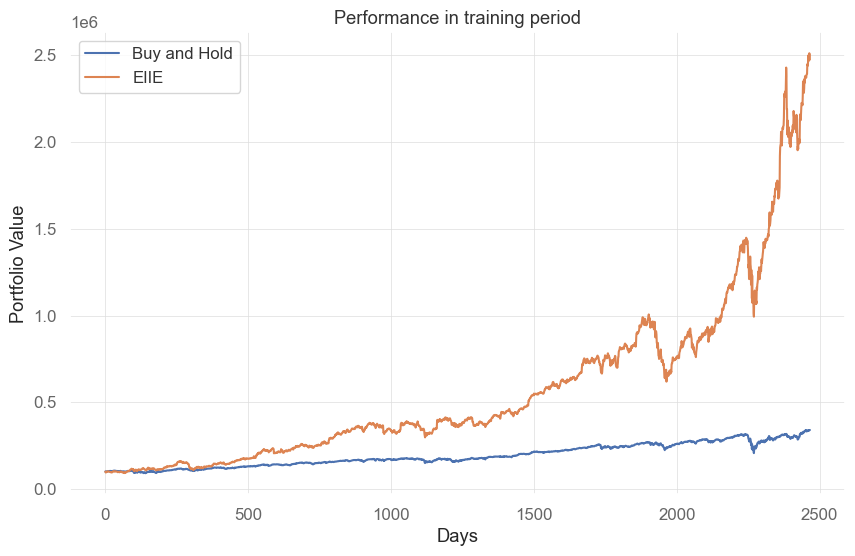

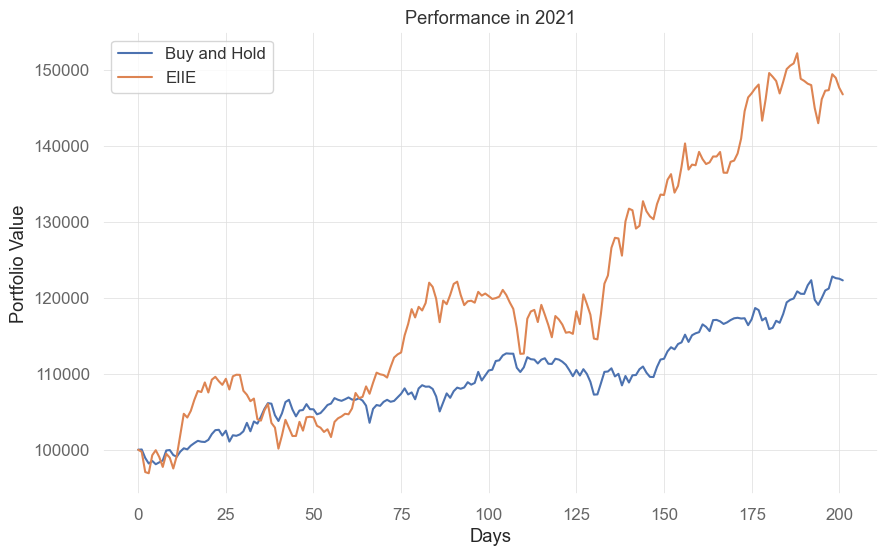

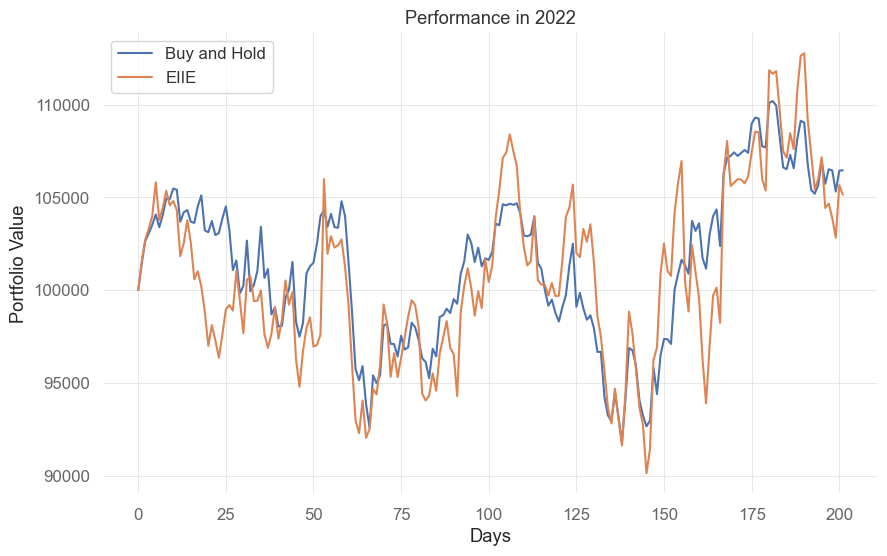

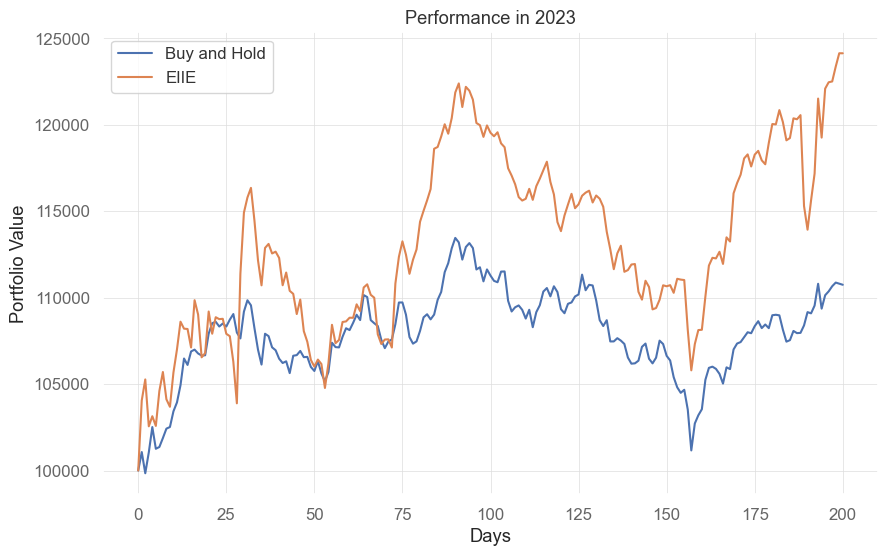

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")
#plt.plot(EI3_results["train"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")
#plt.plot(EI3_results["2021"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")
#plt.plot(EI3_results["2022"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

plt.plot(UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["value"], label="EIIE")
#plt.plot(EI3_results["2023"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()

# Portfolio Allocation by Trained DRL Model

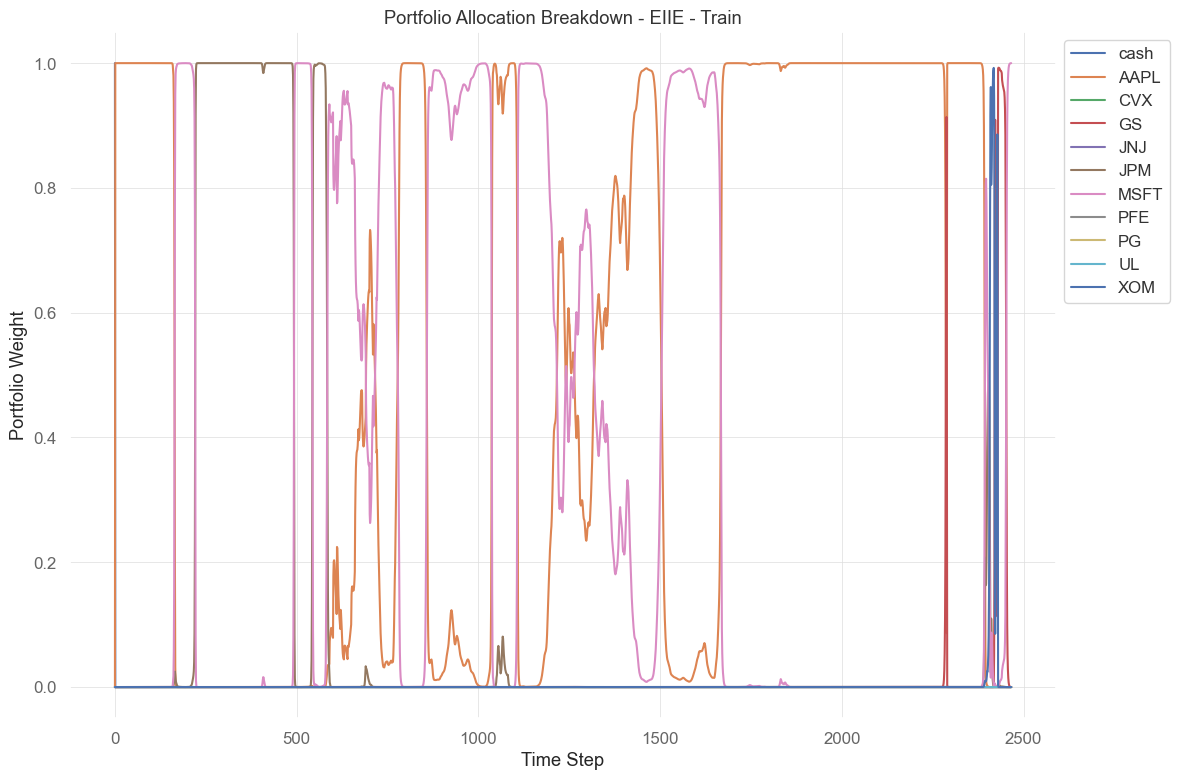

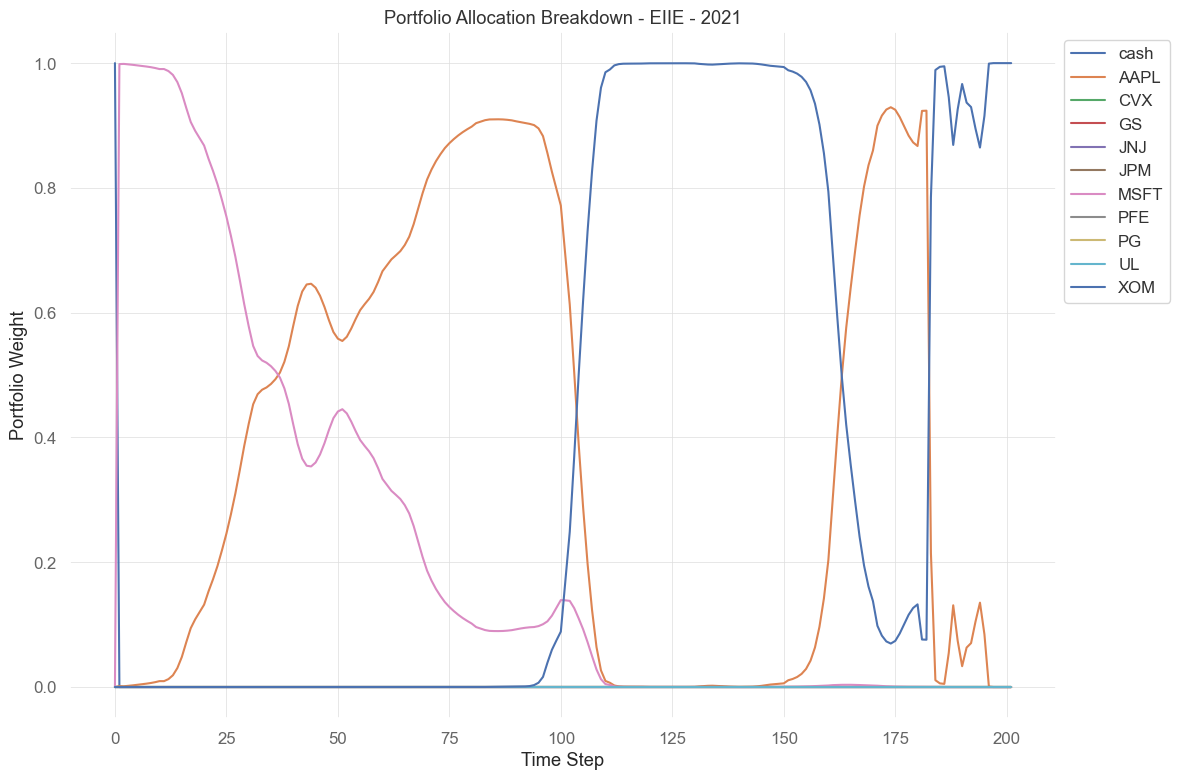

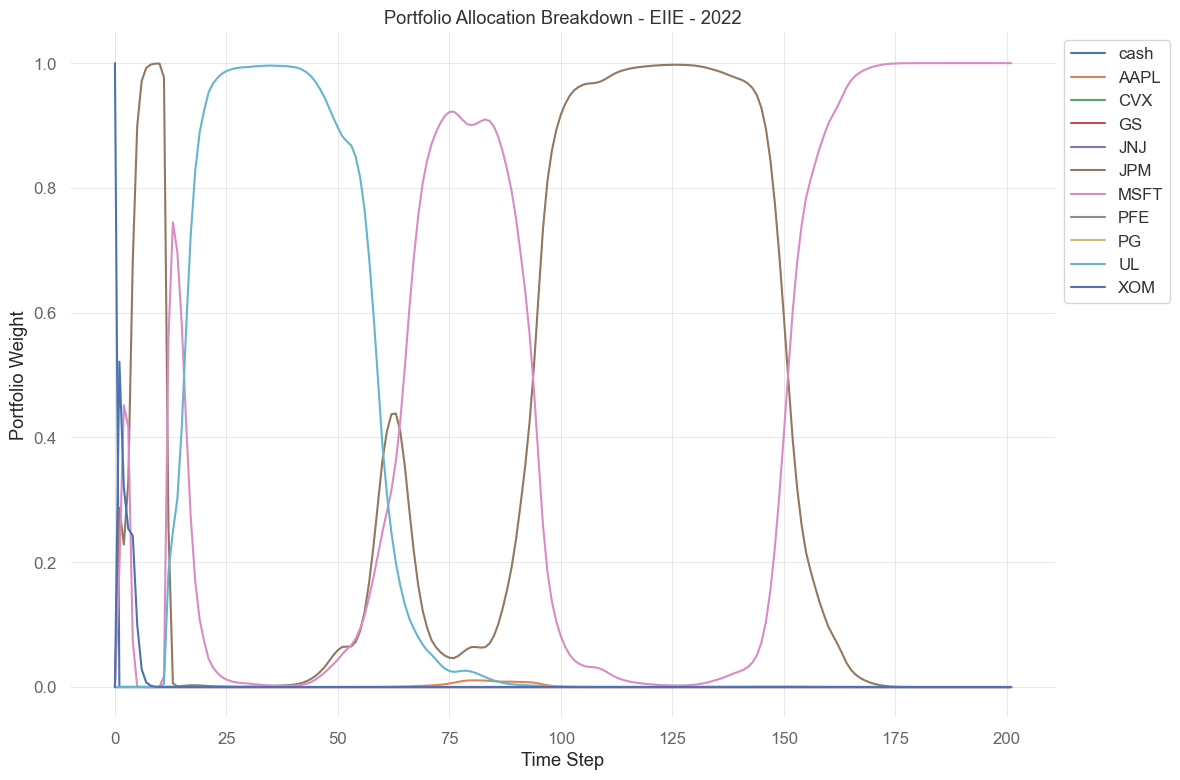

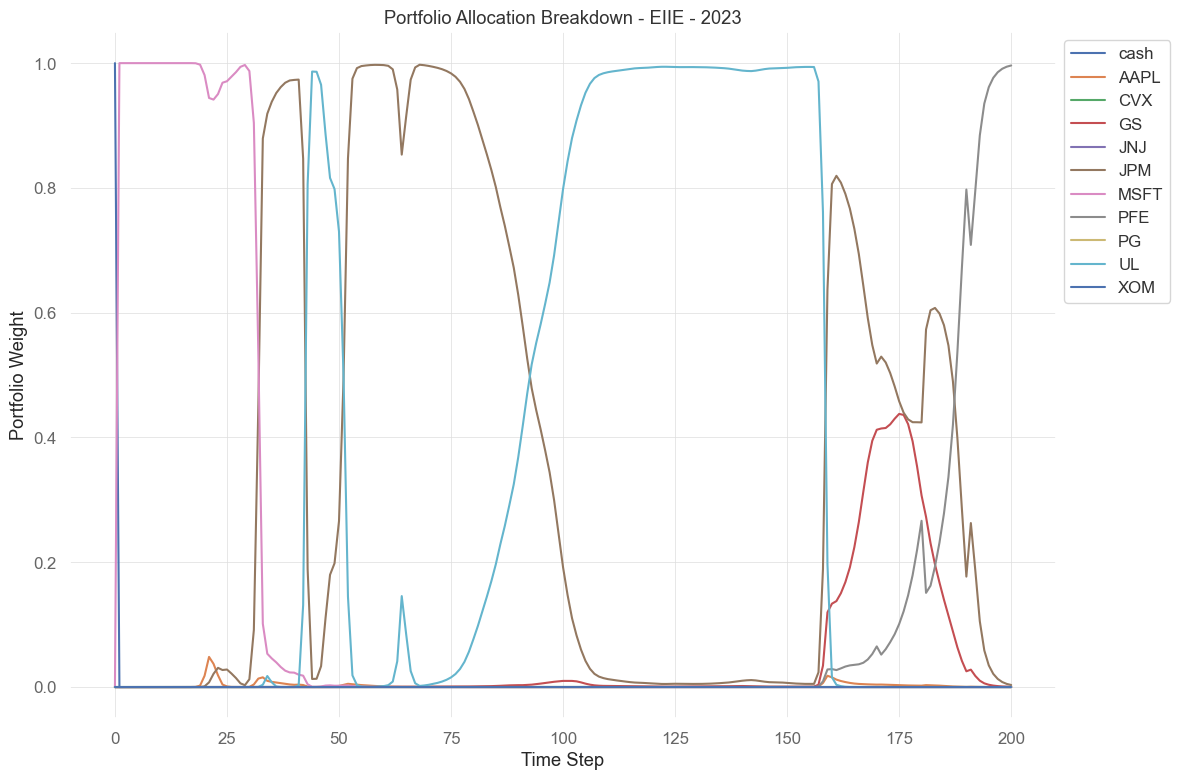

In [15]:
# Function to plot action memory
def plot_action_memory(actions, tickers, label):
    """Visualize portfolio allocation over time."""
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    actions_df.plot(kind="line", figsize=(12, 8), title=f"Portfolio Allocation Breakdown - {label}")
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Time Step")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot EIIE actions for the training period
plot_action_memory(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train")

# Plot EIIE actions for 2021
plot_action_memory(EIIE_results["2021"]["actions"], TEST_SET, "EIIE - 2021")

# Plot EIIE actions for 2022
plot_action_memory(EIIE_results["2022"]["actions"], TEST_SET, "EIIE - 2022")

# Plot EIIE actions for 2023
plot_action_memory(EIIE_results["2023"]["actions"], TEST_SET, "EIIE - 2023")

# Similarly, plot UBAH actions for each period
# plot_action_memory(UBAH_results["train"]["actions"], TEST_SET, "UBAH - Train")
# plot_action_memory(UBAH_results["2021"]["actions"], TEST_SET, "UBAH - 2021")
# plot_action_memory(UBAH_results["2022"]["actions"], TEST_SET, "UBAH - 2022")
# plot_action_memory(UBAH_results["2023"]["actions"], TEST_SET, "UBAH - 2023")